In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Static inline plots
%matplotlib inline

# Interactive plots
# %matplotlib notebook

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage
import joblib
import datetime

timer = mypackage.Timer()

def print_current_time():
    print(datetime.datetime.now())

TensorFlow version is 2.1.0


Using TensorFlow backend.


In [2]:
import datetime

def print_current_time():
    print(datetime.datetime.now())
    
print_current_time()

2020-05-17 11:21:24.882464


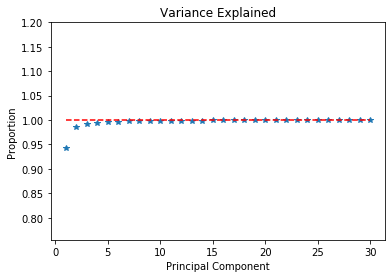

In [3]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra_all", only_with_contaminant=True)

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)

X_test_orig, X_train_orig, scaler = mypackage.Dataset.scale(X_test_orig, X_train_orig, scaler='GlobalStandardization')

X_train_orig, X_test_orig = mypackage.Dataset.PCA(X_train_orig, X_test_orig, n_components=30, plot=True, whiten=True)

# save the scaler to disk
filename = 'latest_scaler_used.sav'
joblib.dump(scaler, filename)
# load the scaler from disk
scaler = joblib.load(filename)

zoom = lambda X, Y, size, mp, noise=0.3: mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=size, 
                                                             sample_multiplication=mp, contaminant_type=2,
                                                             zoom_with_noise=noise, flip=True)

In [4]:
######################################################
# Need extra padding for the HybridSN classification
window_size = 25
margin = int((window_size - 1) / 2)
padding = margin * 2
size = 32 + padding

s, m = size, 3 # Each HybridSN takes 1 hour to run with m=3 and PCA->30
X_train_HS, Y_train_HS = zoom(X_train_orig, Y_train_orig, s, m, noise=0.0)
X_test_HS,  Y_test_HS  = zoom(X_test_orig,  Y_test_orig,  s, m, noise=0.0)
#######################################################

X_train_HS.shape, X_test_HS.shape

((126, 56, 56, 30), (57, 56, 56, 30))

# Test HybridSN

2020-05-16 23:47:58.879299
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 30, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 24, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 20, 16)    5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 18, 32)    13856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 576)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        331840    
_________________________________________________________________
flatten_1 (Flatten)          (No

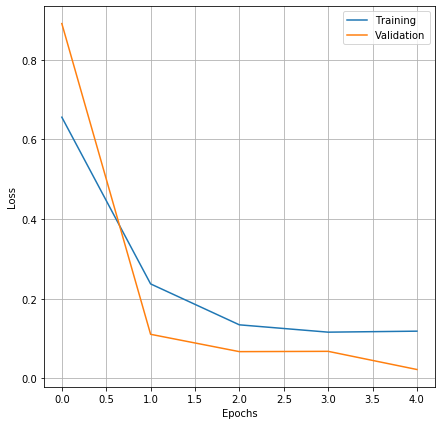

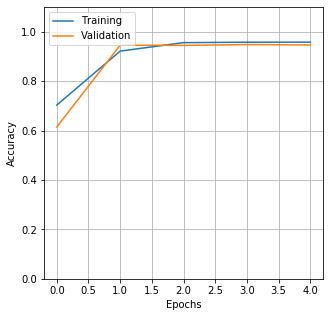

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     35071
         1.0       0.90      0.96      0.93     21517
         2.0       0.00      0.00      0.00      1780

    accuracy                           0.95     58368
   macro avg       0.63      0.65      0.64     58368
weighted avg       0.92      0.95      0.93     58368



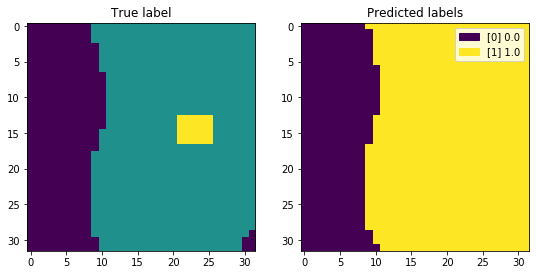

Elapsed time: 477.7914 seconds
Fasle positive blobs 2.
Fasle positive blobs per image 0.0351


In [5]:
print_current_time()

model = mypackage.HybridSN(X_train_HS, Y_train_HS, X_test_HS, Y_test_HS)
model.summary()

timer.start()
model.train(epochs=5)
timer.stop()

model.plot_training_results()
# model.predict(X_train_HS, Y_train_HS)
timer.start()
Y_hat = model.predict(X_test_HS, Y_test_HS)
timer.stop()
mypackage.report_count_false_positive(Y_hat, Y_test_HS)

In [4]:
# Moved this here to fix problems with HybridSN
s, m = 32, 30
X_train, Y_train = zoom(X_train_orig, Y_train_orig, s, m)
X_test,  Y_test  = zoom(X_test_orig,  Y_test_orig,  s, m)

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))

[0. 1. 2.] (570, 32, 32, 1) (-18.315452575683594, 24.86630630493164) (570, 32, 32, 30) (1260, 32, 32, 30)
(array([0., 1., 2.]), array([915901, 343432,  30907]))
(array([0., 1., 2.]), array([372405, 194964,  16311]))


# Testing SVM

In [7]:
# Started the training at ~16:30
# Finished training at ~17:00

In [8]:
Y_train_orig.shape, Y_test_orig.shape, X_train_orig.shape

((42, 100, 100, 1), (19, 100, 100, 1), (42, 100, 100, 30))

2020-05-17 02:18:33.027931
[LibSVM]Elapsed time: 742.5985 seconds
Elapsed time: 260.5792 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    361370
         1.0       0.98      0.97      0.97    204942
         2.0       0.91      0.80      0.85     17368

    accuracy                           0.98    583680
   macro avg       0.96      0.92      0.94    583680
weighted avg       0.98      0.98      0.98    583680

Fasle positive blobs 126.
Fasle positive blobs per image 0.2211


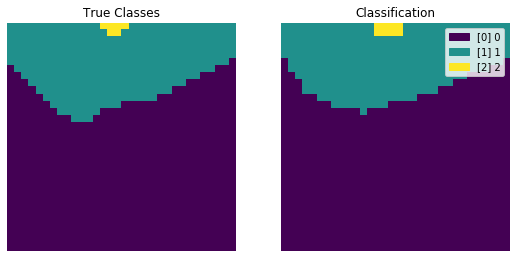

In [9]:
print_current_time()

svm = mypackage.SVM(X_train_orig, Y_train_orig, C=100, kernel='rbf', gamma=0.001)
svm.train()
# svm.predict(X_train, Y_train, plot=False)
Y_hat = svm.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

### Linear - SVM

2020-05-17 02:35:17.052577
[LibSVM]Elapsed time: 2118.7146 seconds
Elapsed time: 157.7315 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    361370
         1.0       0.97      0.97      0.97    204942
         2.0       0.90      0.72      0.80     17368

    accuracy                           0.98    583680
   macro avg       0.95      0.89      0.92    583680
weighted avg       0.98      0.98      0.98    583680

Fasle positive blobs 220.
Fasle positive blobs per image 0.3860


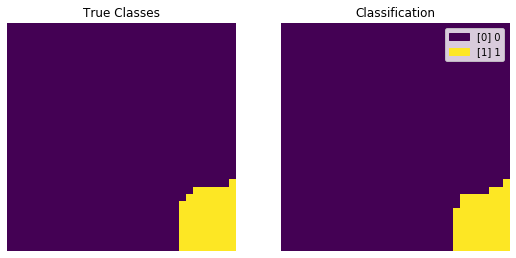

In [10]:
print_current_time()

svm = mypackage.SVM(X_train_orig, Y_train_orig, C=1, kernel='linear')
svm.train()
# svm.predict(X_train, Y_train, plot=False)
Y_hat = svm.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

In [11]:
# mypackage.plot_labeled_images(Y_hat, Y_test_svm)

# Testing Logistic Regression

2020-05-17 03:13:14.384987
Elapsed time: 4.4361 seconds
Elapsed time: 0.1497 seconds
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    910135
         1.0       0.95      0.96      0.96    345929
         2.0       0.89      0.58      0.70     34176

    accuracy                           0.98   1290240
   macro avg       0.94      0.85      0.88   1290240
weighted avg       0.97      0.98      0.97   1290240

Elapsed time: 0.0658 seconds
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    361370
         1.0       0.97      0.96      0.97    204942
         2.0       0.89      0.70      0.78     17368

    accuracy                           0.98    583680
   macro avg       0.95      0.89      0.91    583680
weighted avg       0.98      0.98      0.98    583680

Fasle positive blobs 256.
Fasle positive blobs per image 0.4491


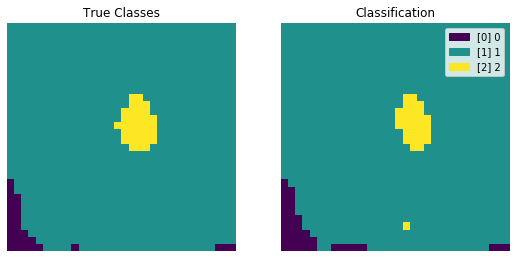

In [12]:
print_current_time()

logreg = mypackage.LogReg(X_train_orig, Y_train_orig, C=1000, penalty='l2', saved_mode_name="latest_LogisticReg_l2_model.sav")# , max_iter=1000)
logreg.train()
logreg.predict(X_train, Y_train, plot=False)
Y_hat = logreg.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

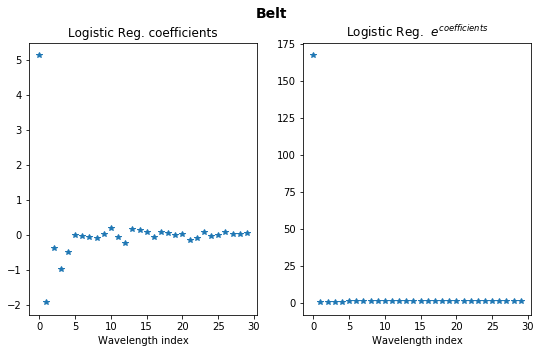

Ordered four most useful wavelengths are: [928, 964, 975, 978]nm
There corresponding indexes are: [ 0 10 13 14]


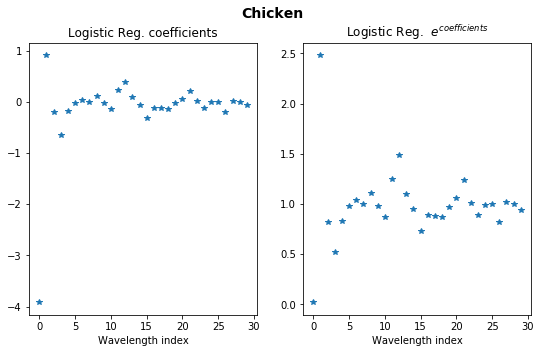

Ordered four most useful wavelengths are: [932, 971, 968, 1004]nm
There corresponding indexes are: [ 1 12 11 21]


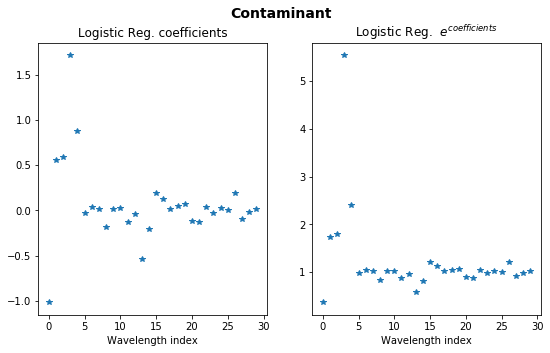

Ordered four most useful wavelengths are: [939, 942, 935, 932]nm
There corresponding indexes are: [3 4 2 1]


In [13]:
# logit(p) = log(p/(1-p)) = \beta_0 + \beta_1*w1+...+ \beta_209*w209
label = {0: 'Belt', 1: 'Chicken', 2: 'Contaminant'}
for i in range(3):
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title('Logistic Reg. coefficients')
    plt.plot(logreg.classifier.coef_[i, :], '*')
    plt.xlabel("Wavelength index")
    plt.subplot(122)
    plt.title(r'Logistic Reg.  $e^{coefficients}$')
    exp_coef = np.exp(logreg.classifier.coef_[i, :])
    plt.plot(exp_coef, '*')
    plt.xlabel("Wavelength index")
#     plt.tight_layout()
    plt.suptitle(label[i], fontsize=14, fontweight='bold')
    plt.show()
    top_index = exp_coef.argsort()[-4:][::-1]
    print(f"Ordered four most useful wavelengths are: {[mypackage.Dataset.TOMRA_WAVELENGTHS[i] for i in top_index]}nm")
    print(f"There corresponding indexes are: {top_index}")

In [14]:
np.unique(Y_train_orig, return_counts=True)

(array([0, 1, 2], dtype=int32), array([361057,  54747,   4196]))

2020-05-17 03:13:22.475690


/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Elapsed time: 6.7578 seconds
2020-05-17 03:13:29.235041
Elapsed time: 0.0657 seconds
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    361370
         1.0       0.97      0.96      0.97    204942
         2.0       0.89      0.69      0.78     17368

    accuracy                           0.98    583680
   macro avg       0.95      0.88      0.91    583680
weighted avg       0.98      0.98      0.98    583680

2020-05-17 03:13:29.958347
Fasle positive blobs 245.
Fasle positive blobs per image 0.4298


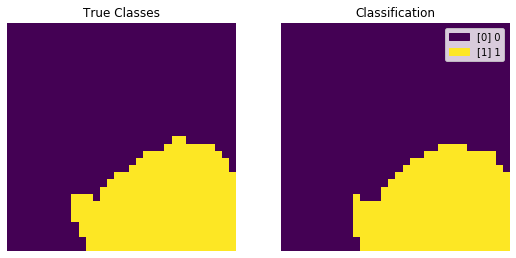

In [15]:
print_current_time()

logreg_l1 = mypackage.LogReg(X_train_orig, Y_train_orig, C=0.1, penalty='l1', max_iter=10, saved_mode_name="latest_LogisticReg_l1_model.sav")# , max_iter=1000)
logreg_l1.train()
# logreg_l1.predict(X_train, Y_train, plot=False)
print_current_time()
Y_hat = logreg_l1.predict(X_test, Y_test)
print_current_time()

mypackage.report_count_false_positive(Y_hat, Y_test)

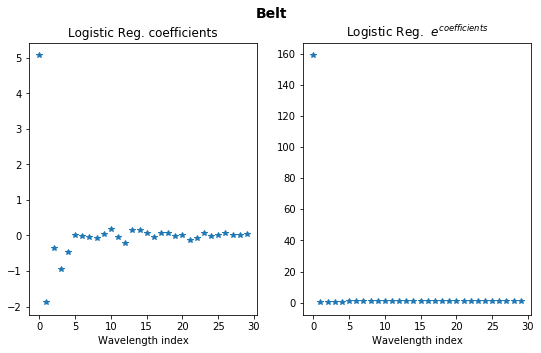

Ordered four most useful wavelengths are: [928, 964, 975, 978]nm
There corresponding indexes are: [ 0 10 13 14]


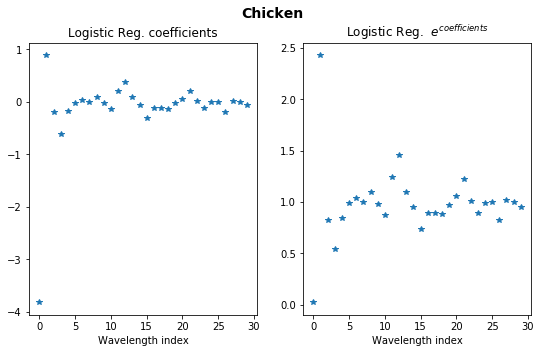

Ordered four most useful wavelengths are: [932, 971, 968, 1004]nm
There corresponding indexes are: [ 1 12 11 21]


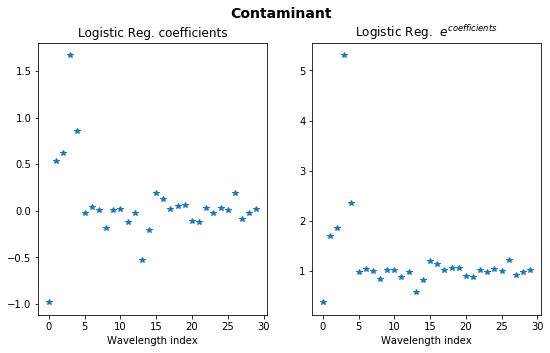

Ordered four most useful wavelengths are: [939, 942, 935, 932]nm
There corresponding indexes are: [3 4 2 1]


In [16]:
# logit(p) = log(p/(1-p)) = \beta_0 + \beta_1*w1+...+ \beta_209*w209
label = {0: 'Belt', 1: 'Chicken', 2: 'Contaminant'}
for i in range(3):
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title('Logistic Reg. coefficients')
    plt.plot(logreg_l1.classifier.coef_[i, :], '*')
    plt.xlabel("Wavelength index")
    plt.subplot(122)
    plt.title(r'Logistic Reg.  $e^{coefficients}$')
    exp_coef = np.exp(logreg_l1.classifier.coef_[i, :])
    plt.plot(exp_coef, '*')
    plt.xlabel("Wavelength index")
#     plt.tight_layout()
    plt.suptitle(label[i], fontsize=14, fontweight='bold')
    plt.show()
    top_index = exp_coef.argsort()[-4:][::-1]
    print(f"Ordered four most useful wavelengths are: {[mypackage.Dataset.TOMRA_WAVELENGTHS[i] for i in top_index]}nm")
    print(f"There corresponding indexes are: {top_index}")

In [17]:
# mypackage.plot_labeled_images(Y_hat, Y_test)

In [18]:
X_train_orig.shape

(42, 100, 100, 30)

In [19]:
# # train = mypackage.StackTransform(X_test_orig, Y_test_orig)
# Y_hat_train = logreg.predict(X_train_orig)
# # Y_hat_train = train.Unstack(Y_test_orig, k=1)
# print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat_train, Y_train_orig)}")

# for i in range(len(Y_train_orig)):
#     if 2 in Y_train_orig[i]:
#         plt.figure(figsize=(9, 6))
#         plt.subplot(121)
#         img = plt.imshow(np.squeeze(Y_hat_train[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_hat_train[i], img)
#         plt.title("Predicted labels")
#         plt.subplot(122)
#         img = plt.imshow(np.squeeze(Y_train_orig[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_train_orig[i], img)
#         plt.title("True labels")

In [20]:
# # train = mypackage.StackTransform(X_test_orig, Y_test_orig)
# Y_hat_test = logreg.predict(X_test_orig)
# # Y_hat_train = train.Unstack(Y_test_orig, k=1)
# print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat_test, Y_test_orig)}")

# for i in range(len(Y_test_orig)):
#     if 2 in Y_test_orig[i]:
#         plt.figure(figsize=(9, 6))
#         plt.subplot(121)
#         img = plt.imshow(np.squeeze(Y_hat_test[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_hat_test[i], img)
#         plt.title("Predicted labels")
#         plt.subplot(122)
#         img = plt.imshow(np.squeeze(Y_test_orig[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_test_orig[i], img)
#         plt.title("True labels")

### Test SpectralUNet on the same data

In [21]:
# spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
# print("Start training")

# spectral_unet.summary()

In [22]:
# import tensorflow as tf

# tf.keras.utils.plot_model(spectral_unet.model, show_shapes=True, show_layer_names=False)

2020-05-17 11:21:45.095773
Start training
Elapsed time: 305.7061 seconds


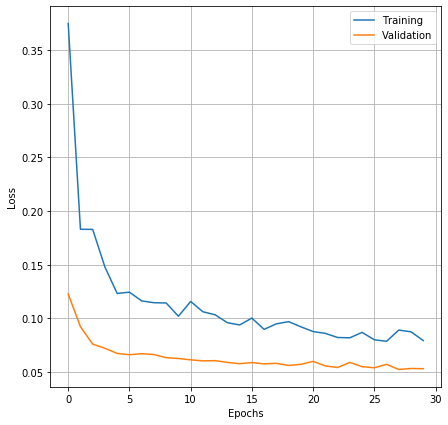

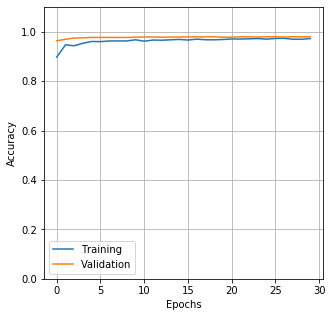

Predicting for train data
Elapsed time: 2.8350 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    915901
           1       0.96      0.97      0.96    343432
           2       0.82      0.79      0.80     30907

    accuracy                           0.98   1290240
   macro avg       0.92      0.92      0.92   1290240
weighted avg       0.98      0.98      0.98   1290240



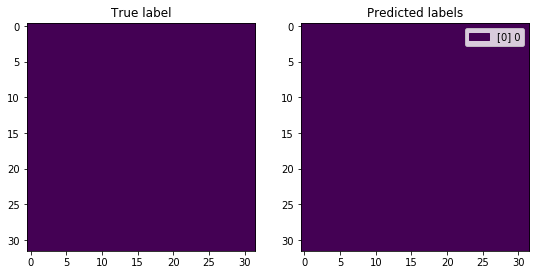

Predicting for test data
Elapsed time: 1.2055 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    372405
           1       0.97      0.96      0.96    194964
           2       0.80      0.81      0.80     16311

    accuracy                           0.98    583680
   macro avg       0.92      0.92      0.92    583680
weighted avg       0.98      0.98      0.98    583680



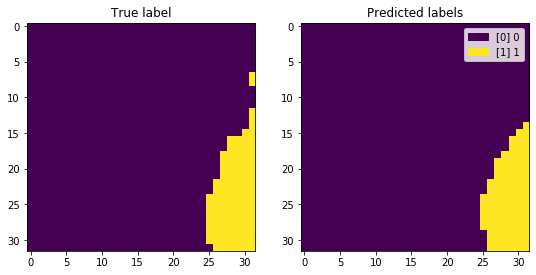

Elapsed time: 2.0697 seconds
Fasle positive blobs 3.
Fasle positive blobs per image 0.0053


In [5]:
print_current_time()

spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
spectral_unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=0)
timer.stop()

# spectral_unet.summary()
spectral_unet.plot_training_results()
print("Predicting for train data")
spectral_unet.predict(X_train, Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = spectral_unet.predict(X_test, Y_labels=Y_test);
timer.stop()
mypackage.report_count_false_positive(y_pred_test, Y_test)

In [24]:
# spectral_unet.summary()

### Test 2D UNet on the same data

2020-05-17 03:18:27.237259
(1260, 32, 32, 30)
Start training
Train on 1134 samples, validate on 126 samples
Epoch 1/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.4785 - accuracy: 0.8772
Epoch 00001: val_loss improved from inf to 0.14556, saving model to latest_unet.hdf5
1134/1134 [==============================] - 5s 4ms/sample - loss: 0.4771 - accuracy: 0.8778 - val_loss: 0.1456 - val_accuracy: 0.9704
Epoch 2/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.1676 - accuracy: 0.9581
Epoch 00002: val_loss improved from 0.14556 to 0.07760, saving model to latest_unet.hdf5
1134/1134 [==============================] - 4s 3ms/sample - loss: 0.1673 - accuracy: 0.9581 - val_loss: 0.0776 - val_accuracy: 0.9776
Epoch 3/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9645
Epoch 00003: val_loss improved from 0.07760 to 0.06350, saving model to latest_unet.hdf5
1134/1134 [==============================] - 4s 3ms/sample - loss

Epoch 28/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.0661 - accuracy: 0.9769
Epoch 00028: val_loss did not improve from 0.04660
1134/1134 [==============================] - 3s 3ms/sample - loss: 0.0675 - accuracy: 0.9766 - val_loss: 0.0504 - val_accuracy: 0.9807
Epoch 29/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9783
Epoch 00029: val_loss did not improve from 0.04660
1134/1134 [==============================] - 3s 3ms/sample - loss: 0.0613 - accuracy: 0.9784 - val_loss: 0.0551 - val_accuracy: 0.9788
Epoch 30/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.0654 - accuracy: 0.9771
Epoch 00030: val_loss did not improve from 0.04660
1134/1134 [==============================] - 3s 3ms/sample - loss: 0.0653 - accuracy: 0.9771 - val_loss: 0.0577 - val_accuracy: 0.9782
Elapsed time: 106.5179 seconds


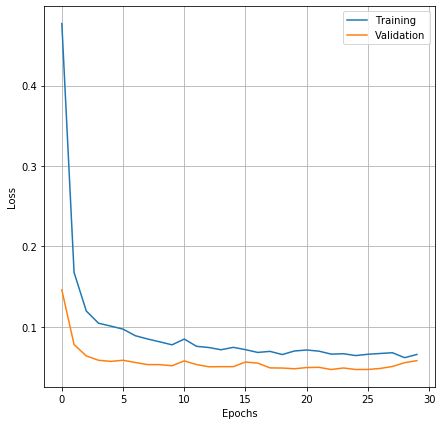

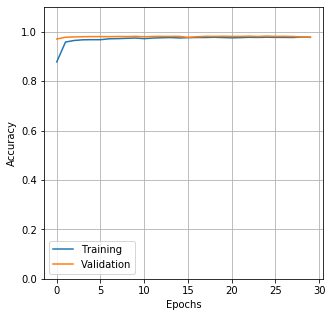

Predicting for train data
Elapsed time: 0.8446 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    910135
           1       0.96      0.97      0.97    345929
           2       0.90      0.73      0.81     34176

    accuracy                           0.98   1290240
   macro avg       0.95      0.90      0.92   1290240
weighted avg       0.98      0.98      0.98   1290240



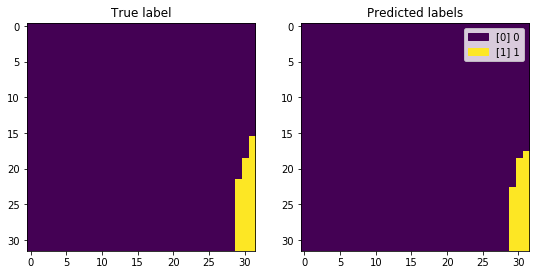

Predicting for test data
Elapsed time: 0.3100 seconds
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    361370
           1       0.98      0.96      0.97    204942
           2       0.88      0.78      0.83     17368

    accuracy                           0.98    583680
   macro avg       0.95      0.91      0.93    583680
weighted avg       0.98      0.98      0.98    583680



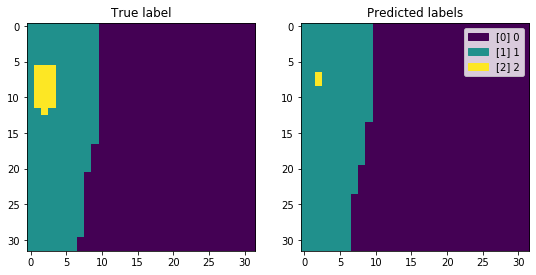

Elapsed time: 1.1543 seconds
Fasle positive blobs 48.
Fasle positive blobs per image 0.0842
Number of layers in the base model:  49


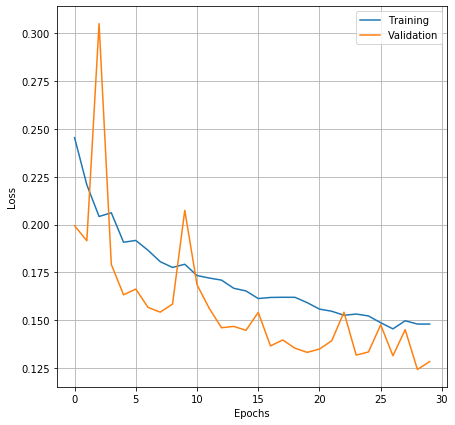

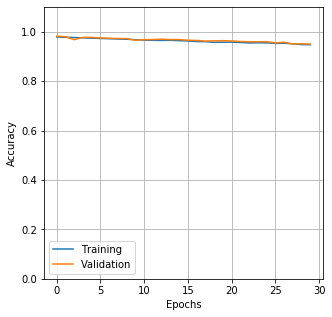

Predicting for test data after Dice_Loss focus on contaminants
Elapsed time: 0.4962 seconds
              precision    recall  f1-score   support

           0       0.94      0.99      0.96    361370
           1       0.97      0.87      0.92    204942
           2       0.87      0.84      0.86     17368

    accuracy                           0.95    583680
   macro avg       0.93      0.90      0.91    583680
weighted avg       0.95      0.95      0.94    583680



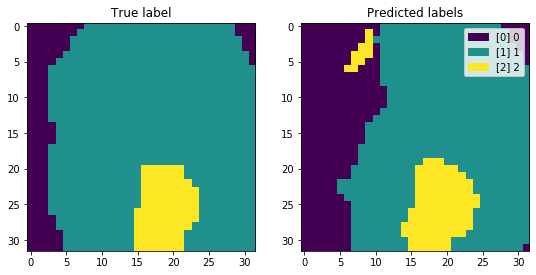

Fasle positive blobs 62.
Fasle positive blobs per image 0.1088


In [25]:
print_current_time()

# I would like to use as input these channels
# 7: 953nm, 40: 1072, 68: 1173nm, 138: 1426nm, -1: 1674nm -> 1173nm, 1426nm, 1674nm match to the expected based on labratory measurements
channels_used = [] # [7, 40, 68, 138, -1]
def select_channels(X_train):
    if X_train.shape[-1] <= 30:
        return X_train
    elif channels_used != []:
        return X_train[..., channels_used]
    else:
        return X_train
    
print(select_channels(X_train).shape)
unet = mypackage.UNet(select_channels(X_train), Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
# TODO: Test this more: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU -> monitor='val_mean_io_u'
unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=1)
timer.stop()

# unet.summary()
unet.plot_training_results()
print("Predicting for train data")
unet.predict(select_channels(X_train), Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = unet.predict(select_channels(X_test), Y_labels=Y_test);
timer.stop()
mypackage.report_count_false_positive(y_pred_test, Y_test)

tl = lambda y_true, y_pred: mypackage.lf.tversky_loss(y_true, y_pred, only_contaminant=True)
unet.retrain(select_channels(X_train), Y_train, batch_size=20, epochs=30, loss=tl, validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after Dice_Loss focus on contaminants")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
mypackage.report_count_false_positive(y_pred_test, Y_test)

In [26]:
# def get_classification_heat_map(y_hat, heat_maps):
#     heat = np.zeros(y_hat.shape)
#     heat[y_hat == 0] = heat_maps[..., 0][y_hat == 0]
#     heat[y_hat == 1] = heat_maps[..., 1][y_hat == 1]
#     heat[y_hat == 2] = heat_maps[..., 2][y_hat == 2]
#     return heat

# def plot_with_heat_map(y_hat, heat_maps, y):
#     heat = get_classification_heat_map(y_hat, heat_maps)

#     plt.figure(figsize=(12, 6))
#     plt.subplot(131)
#     plt.imshow(heat)
#     plt.colorbar()
#     plt.title("Model confidence of classification")
#     plt.subplot(132)
#     img = plt.imshow(y_hat)
#     mypackage.Dataset._Dataset__add_legend_to_image(y_hat, img)
#     plt.title("Predicted labels")
#     plt.subplot(133)
#     img = plt.imshow(np.squeeze(y))
#     mypackage.Dataset._Dataset__add_legend_to_image(y, img)
#     plt.title("True labels")

# # y_pred_test, y_pred_heat = unet.predict(X_test[..., channels_used], Y_labels=Y_test, return_heat_map=True);
# for i in range(len(Y_test)):
#     if 2 in Y_test[i]:
#         plot_with_heat_map(y_pred_test[i], y_pred_heat[i], Y_test[i])
#         plt.suptitle(i)
        

Number of layers in the base model:  49


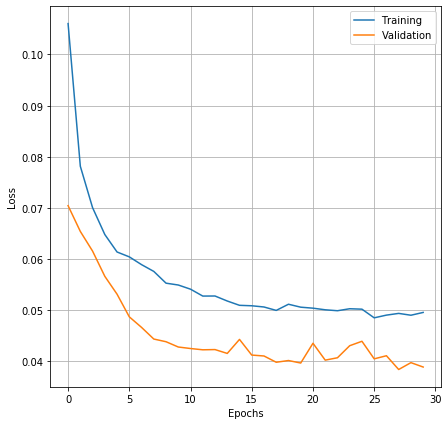

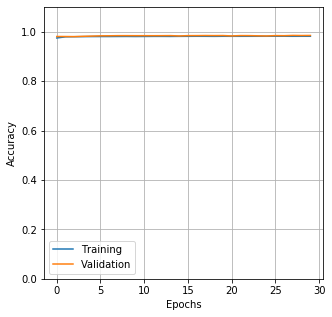

Predicting for test data after CategoricalCrossEntropy followed by Dice_Loss and then CategoricalCross again
Elapsed time: 0.4995 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    361370
           1       0.98      0.96      0.97    204942
           2       0.86      0.85      0.85     17368

    accuracy                           0.98    583680
   macro avg       0.94      0.94      0.94    583680
weighted avg       0.98      0.98      0.98    583680



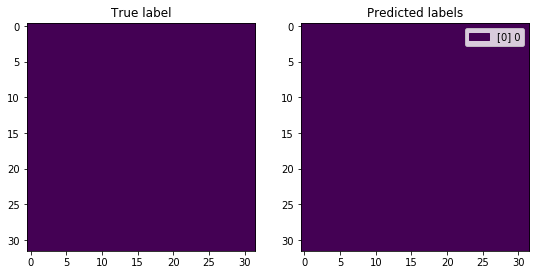

Fasle positive blobs 42.
Fasle positive blobs per image 0.0737


In [27]:
unet.retrain(select_channels(X_train), Y_train, batch_size=20, epochs=30, loss="categorical_crossentropy", validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after CategoricalCrossEntropy followed by Dice_Loss and then CategoricalCross again")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
mypackage.report_count_false_positive(y_pred_test, Y_test)

##################################
# Additional HybridSN prediction #
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     20992
         1.0       0.74      0.95      0.83     11836
         2.0       0.00      0.00      0.00      3652

    accuracy                           0.88     36480
   macro avg       0.57      0.65      0.61     36480
weighted avg       0.80      0.88      0.84     36480



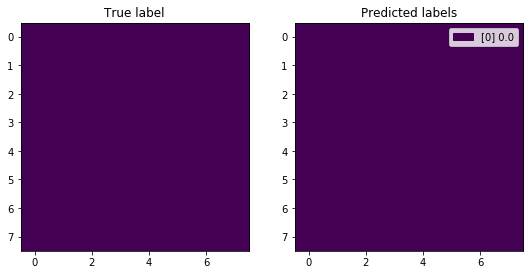

Elapsed time: 300.2996 seconds
Fasle positive blobs 2.
Fasle positive blobs per image 0.0035


In [28]:
model_hsn = mypackage.HybridSN(X_train_HS, Y_train_HS, X_test_HS, Y_test_HS)

print("##################################")
print("# Additional HybridSN prediction #")
timer.start()
Y_hat = model_hsn.predict(X_test, Y_test)
timer.stop()
mypackage.report_count_false_positive(Y_hat, Y_test)

Summary runtimes
HybridSN
    X_test_HS -> (57, 56, 56, 208)
    586.6562 seconds
    10.2922 sec per image

X_test -> (570, 32, 32, 1)

SVM RBF    - 2109.1566 seconds -> 3.7003
SVM Linear - 3243.4765 seconds -> 5.6903

LR l2 - 0.3546 seconds -> 0.0006
LR l1 - 

SpectralUNet - 7.3087 seconds -> 0.0128
UNet - 1.0001 seconds -> 0.0018
UNet +DL - 1.2491     -> 0,0022
UNet +DL+CCE - 1.1801 -> 0,0021